## This notebook investigates how to stitch together multiple time windows for exploring jerks in the path model 


In [2]:
import sys
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
sys.path.append( os.path.abspath('..') ) #This line needs to point to whereever the jerks module has been compiled.
from jerks import jerks

In [3]:
# Download the spherical harmonic time-series output from the path model
import os.path
if not os.path.exists('Gauss_Bsurf.mat'): 
    !wget http://morpho.ipgp.fr/4DEarth/Gauss_Bsurf.mat

In [4]:
# import the (Matlab formatted) dataset
import h5py
filepath = 'Gauss_Bsurf.mat'
arrays = {}
f = h5py.File(filepath,'r')
for k, v in f.items():
    arrays[k] = np.array(v)

In [5]:
coeffs = arrays['gnm'][:,:].T
time = arrays['timers'].flatten()
print( 'Shape of gmn array: ', arrays['gnm'].shape )
print ('Times (in years) of output', time )

Shape of gmn array:  (960, 50001)
Times (in years) of output [ 4200.   4200.2  4200.4 ... 14199.6 14199.8 14200. ]


In [6]:
# jerk times as defined in catalogue
jerk_times = [4600,5750,2920, 1915, 6490,7300,7620,7840,8880,9673,10590,12620,13411,13546]

In [7]:
import chaosmagpy as cp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec



# Analysis of jerk 9: stitch together multiple timeseries

##### Run jerk finder using segments, with overlap. 
##### Use: chain length of 1M, and 10% relative error

In [179]:
window_length = 400
overlap = 50

window_start = np.arange(time.min(), 8000, window_length) #time.max(), window_length)
window_end= window_start + window_length

window_overlap_start = [max(i-overlap,time.min())  for i in window_start]
window_overlap_end = [min(i+overlap,time.max())  for i in window_end]

print( list(zip(window_start, window_end)))
print( len(window_start))

[(4200.0, 4600.0), (4600.0, 5000.0), (5000.0, 5400.0), (5400.0, 5800.0), (5800.0, 6200.0), (6200.0, 6600.0), (6600.0, 7000.0), (7000.0, 7400.0), (7400.0, 7800.0), (7800.0, 8200.0)]
10


In [180]:
radius = 6371.
theta = 90
phi = 45
jerk_number = 8 # in Python indexing (i.e. event 9)


# components:
run_components=[0,1,2]
size_jerk_data_stitch  = np.zeros( len(run_components) )
jerk_data_stitch0, jerk_data_stitch1, jerk_data_stitch2 = np.empty(shape=[0, 2]), np.empty(shape=[0, 2]), np.empty(shape=[0, 2])
    
for cmpt in run_components:
    
    # Find min/max SV for whole timeseries
    Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
    time_yearly = np.arange(time.min(), time.max()+1)
    Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), \
    np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
    Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), \
    np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)

    if cmpt == 0:
        SV = Bx_dot
    elif cmpt == 1:
        SV = By_dot
    else:
        SV = Bz_dot
            
    SV_MIN = SV.min() 
    SV_MAX = SV.max()

    # errors defined for whole dataset:
    SV_error = 10

    for window_index in range(len(window_overlap_start)):
        
    # sample every year
        time_yearly = np.arange(window_overlap_start[window_index], window_overlap_end[window_index]+1)
        Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
        Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)
        
        if cmpt == 0:
            SV = Bx_dot
        elif cmpt == 1:
            SV = By_dot
        else:
            SV = Bz_dot

        discretise_size = 100
        TIMES = time_yearly
        NUM_DATA = len(TIMES)
        TIMES_MIN = TIMES.min()
        TIMES_MAX = TIMES.max()
        delta_SV = SV_error * 0.01 * (SV_MAX - SV_MIN) * np.ones(NUM_DATA,dtype=float)

        sigmas = np.array([ (SV_MAX - SV_MIN)*0.08,\
                           (TIMES_MAX - TIMES_MIN)*0.02,(SV_MAX - SV_MIN)*0.08],dtype = float)

        K_MIN = 0
        K_MAX = 100
        THIN = 100
        NBINS = 100
        credible = 0
        RUNNING_MODE = 1
        burn_in = 10000
        NSAMPLE = 1000000+burn_in
        # ****************************************
        # Define diagnostic time bins here
        # ****************************************
        time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
        time_intervals_nbins = time_intervals_edges.shape[0]-1



        size_jerk_data = 0
        jerk_data = np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2),dtype=float )

        TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)

        Acceptance_rates=np.zeros(4)
        AV = np.zeros(discretise_size,dtype=float)
        SUP = np.zeros(discretise_size,dtype=float)
        INF = np.zeros(discretise_size,dtype=float)
        MEDIAN = np.zeros(discretise_size,dtype=float)
        MODE = np.zeros(discretise_size,dtype=float)
        MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
        N_CP_hist = np.zeros( K_MAX, dtype=int)
        av_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
        median_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
        upper_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
        lower_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )

        CP = np.zeros( time_intervals_nbins, dtype=int )

        (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
        median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
        MARGINAL_DENSITY, N_CP_hist, jerk_data, size_jerk_data) = jerks.rjmcmc(
         sigmas=sigmas, burn_in=burn_in, 
         nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
         y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
         k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
         thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)

        # save only the part within the actual (non-overlapping) time window:
        mask = [i for i in range(jerk_data.shape[0]) if (i < size_jerk_data) and \
                (jerk_data[i,0] < window_end[window_index]) and \
                (jerk_data[i,0] > window_start[window_index])]   
# don't worry about jerks falling exactly on the window boundaries, as this happens with probability 0.

        if cmpt == 0:
            jerk_data_stitch0 = np.vstack((jerk_data_stitch0[:,:],jerk_data[mask,:]))
        elif cmpt == 1:
            jerk_data_stitch1 = np.vstack((jerk_data_stitch1[:,:],jerk_data[mask,:]))
        else:
            jerk_data_stitch2 = np.vstack((jerk_data_stitch2[:,:],jerk_data[mask,:]))

        size_jerk_data_stitch[cmpt] += len(mask)

        print('Window index: {0:d}; acceptance rates: {1:3.1f}% {2:3.1f}% {3:3.1f}% {4:3.1f}%'.\
              format(window_index, Acceptance_rates[0],Acceptance_rates[1],Acceptance_rates[2],Acceptance_rates[3] ))


Window index: 0; acceptance rates: 34.7% 46.2% 12.2% 12.2%
Window index: 1; acceptance rates: 35.9% 38.7% 13.1% 13.1%
Window index: 2; acceptance rates: 32.6% 45.5% 12.1% 12.1%
Window index: 3; acceptance rates: 28.4% 44.4% 10.1% 10.2%
Window index: 4; acceptance rates: 34.9% 37.6% 11.5% 11.5%
Window index: 5; acceptance rates: 27.8% 35.8% 10.3% 10.4%
Window index: 6; acceptance rates: 30.9% 43.4% 11.4% 11.4%
Window index: 7; acceptance rates: 37.4% 35.3% 13.8% 13.9%
Window index: 8; acceptance rates: 31.3% 42.5% 11.9% 12.0%
Window index: 9; acceptance rates: 33.8% 41.3% 12.1% 12.1%
Window index: 0; acceptance rates: 30.6% 48.6% 11.6% 11.6%
Window index: 1; acceptance rates: 32.8% 43.7% 11.7% 11.8%
Window index: 2; acceptance rates: 32.2% 41.4% 11.8% 11.8%
Window index: 3; acceptance rates: 34.9% 33.7% 12.7% 12.7%
Window index: 4; acceptance rates: 34.0% 38.7% 11.3% 11.3%
Window index: 5; acceptance rates: 33.3% 39.7% 11.9% 11.9%
Window index: 6; acceptance rates: 36.7% 32.2% 12.3% 12.

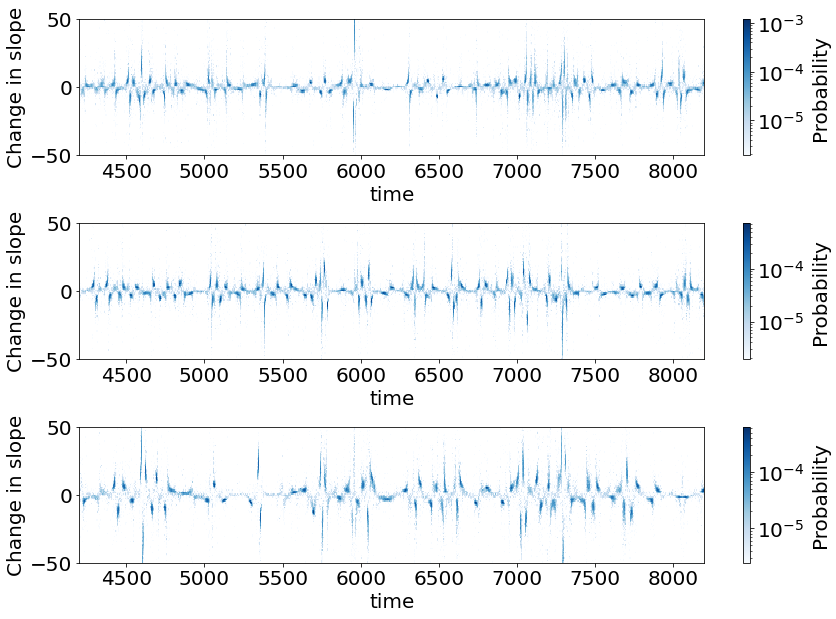

In [186]:
TIMES_MIN, TIMES_MAX = window_start[0], window_end[window_index]
import matplotlib.colors as colors
ax = len(run_components) * [0]
fig, ax = plt.subplots(len(run_components),1, figsize=(14,10))

for i in run_components:
    if i == 0:
        data_timing, data_amplitude = jerk_data_stitch0[:,0], jerk_data_stitch0[:,1]
    elif i==1:
        data_timing, data_amplitude = jerk_data_stitch1[:,0], jerk_data_stitch1[:,1]
    else:
        data_timing, data_amplitude = jerk_data_stitch2[:,0], jerk_data_stitch2[:,1]

    counts, xedges, yedges, im = ax[i].hist2d(data_timing, data_amplitude, bins=(int(TIMES_MAX-TIMES_MIN)*2,100), range=[[TIMES_MIN,TIMES_MAX], [-50,50]],density=True, \
                                       cmap='Blues',norm=colors.LogNorm() )
    cb = fig.colorbar(im, ax=ax[i])
    cb.set_label("Probability", labelpad=6, size=20)
    cb.ax.tick_params(labelsize=20)
    ax[i].tick_params(axis='both', which='major', labelsize=20)
    ax[i].set_xlabel('time', fontsize=20)
    ax[i].set_ylabel('Change in slope', fontsize=20)
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)



In [182]:
# Find jerks:

# 1. Find peaks in marginal histogram of changepoints satisfying criteria like min distance between jerks and jerk prominence, 
# 2. Find the subset of peaks for which the associated modal amplitude (from the 2d histogram) exceeds a certain threshold, label the peak a a jerk
# 3. Find the jerk width by seeing how far either side of the peak the 1d histogram drops to tau of the value at the peak.

# defaults:
# 
def find_jerks(data_timing, data_amplitude, number_time_bins, time_range, 
    number_amplitude_bins = 100, amplitude_range = [-50,50],
    jerk_min_amplitude = 1, min_distance = 4, \
    peak_prominence = 1, tau = 0.14):
    ''' 
    Function: find_jerks
    
    Returns a list of jerk attributes
    
        Parameters:
            data_timing (float, array): changepoint times
            data_amplitude: (float, array): changepoint slope changes
            number_time_bins (integer): number of bins in time
            time_range (list): start and end times
            
            Optional:
            jerk_min_amplitude (float): threshold for jerk identification
            min_distance (float): minimum distance between jerks
            prominence (float): prominence of jerks
            tau (float): threshold to characterise width of jerks
            
        Returns a list of jerk attributes in the form
            [jerk0, jerk1,...]
            where (for example) jerk0 is [jerk_time, jerk_amplitude, min_jerk_time, max_jerk_time]
            All four values are float; jerk_time is the most likely time for a jerk of amplitude jerk_amplitude, but it is uncertain with bounds given by min_jerk_time and max_jerk_time.
            
    Algorithm:
    1. Find peaks in marginal histogram of changepoints satisfying: min distance between jerks and jerk prominence. 
    2. Find the subset of peaks for which the associated slope change of maximum probability (from the 2d histogram) exceeds the threshold of jerk_min_amplitude.  See Scipy documentation for definition of prominence. 
    3. For these peaks ("jerks"), the jerk width is quantified by identifying the smallest time window that defines a drop in the 1d histogram of changepoint timing by tau on both sides. 
    If the changepoint histogram is Gaussian in shape, then 2 sigma corresponds to a drop in height of e^-2, or about 0.14. This defines then (roughly) a 95% credible interval.
    

    '''
    
    jerks_overall_info = []

    

    counts, xedges, yedges = np.histogram2d(data_timing, data_amplitude, bins=(number_time_bins,number_amplitude_bins), range=[time_range, amplitude_range])
    marginal_counts, marginal_xedges = np.histogram( data_timing, bins=number_time_bins, range=time_range)
    from scipy import signal

    peaks = signal.find_peaks(marginal_counts,distance=min_distance, prominence = peak_prominence * marginal_counts.mean() )  

    for peak_index in peaks[0]:
        jerk_info = np.zeros(4)
        index = counts[peak_index,:].argmax()  #find index corresponding to max probability
        jerk_amplitude = 0.5 * ( yedges[index] + yedges[index+1] )  #use the centre point of the bin
        if abs(jerk_amplitude) > jerk_min_amplitude:
            jerk_info[0] = 0.5 * ( marginal_xedges[peak_index] + marginal_xedges[peak_index+1] )  #use the centre point of the bin
            jerk_info[1] = jerk_amplitude

            min_jerk_time = marginal_xedges[0]
            max_jerk_time = marginal_xedges[-1]

            for i in range(peak_index,marginal_counts.shape[0]):  #count upwards in time to find when the jerk window ends
                if marginal_counts[i] < marginal_counts[peak_index] * tau:
                    max_jerk_time = marginal_xedges[i]  #i here indicates the first bin which lies outside the jerk. The edge of the jerk is thus taken to be the left edge of this bin.
                    break

            for i in range(peak_index,0,-1):  # count downwards to find when the jerk window ends
                if marginal_counts[i] < marginal_counts[peak_index] * tau:
                    min_jerk_time = marginal_xedges[i+1]  #i here indicates the first bin which lies outside the jerk. The edge of the jerk is thus taken to be the right edge of this bin.
                    break

            jerk_info[2], jerk_info[3] = min_jerk_time, max_jerk_time

            jerks_overall_info.append(jerk_info)
    return jerks_overall_info

    


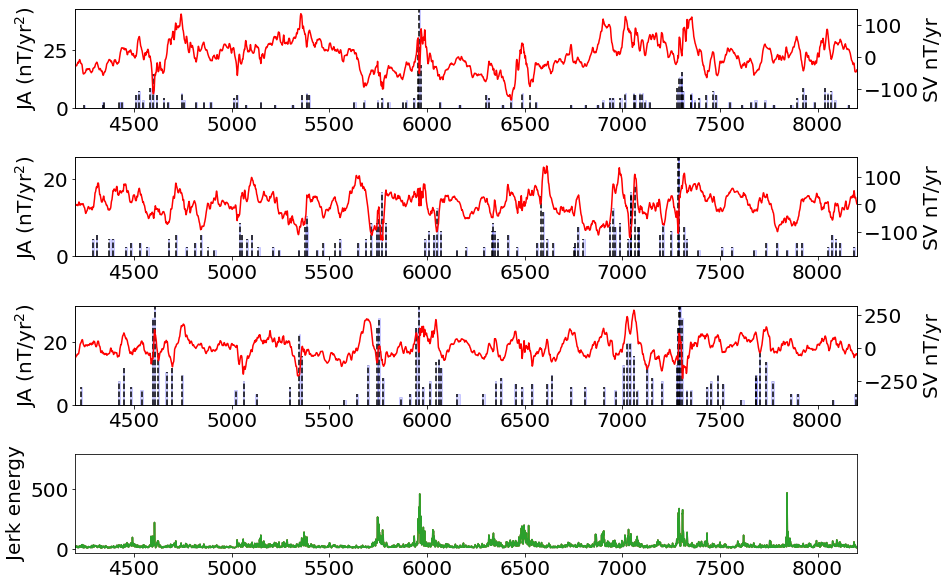

In [187]:
import matplotlib.colors as colors

TIMES_MIN, TIMES_MAX = window_start[0], window_end[window_index]

# Find min/max SV for whole timeseries
Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
time_yearly = np.arange(time.min(), time.max()+1)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), \
np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), \
np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)
    
ax = (len(run_components) + 1) * []

import matplotlib.colors as colors
fig, ax = plt.subplots( len(run_components)+1,1, figsize=(14,10))
for i in run_components:
    if i == 0:
        data_timing, data_amplitude = jerk_data_stitch0[:,0], jerk_data_stitch0[:,1]
    elif i==1:
        data_timing, data_amplitude = jerk_data_stitch1[:,0], jerk_data_stitch1[:,1]
    else:
        data_timing, data_amplitude = jerk_data_stitch2[:,0], jerk_data_stitch2[:,1]
            

    number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
    number_amplitude_bins = 100
    time_range = [TIMES_MIN,TIMES_MAX]
    amplitude_range = [-50,50]
    jerks_info = find_jerks(data_timing, data_amplitude, number_time_bins, time_range, tau = 0.60)


    ax[i].set_ylabel('JA (nT/yr$^2$)', fontsize=20)
    ax[i].tick_params(axis='both', which='major', labelsize=20)
    axb = ax[i].twinx()
    axb.tick_params(axis='y', which='major', labelsize=20)
    axb.set_ylabel('SV nT/yr',fontsize=20)

    if i == 0:
        axb.plot(time_yearly, Bx_dot, 'r')
    elif i == 1:
        axb.plot(time_yearly, By_dot, 'r')
    else:
        axb.plot(time_yearly, Bz_dot, 'r')
        
    ax[i].set_xlim(TIMES_MIN, TIMES_MAX)
    ymin = 0
    ymax = max(jerk[1] for jerk in jerks_info)
    ax[i].set_ylim([ymin,ymax])
    for jerk in jerks_info:
        ax[i].vlines(jerk[0], ymin, abs(jerk[1]), colors='k',linestyles='dashed')
        ax[i].fill_betweenx([ymin, abs(jerk[1])], jerk[2], jerk[3],alpha=0.15, color='blue')
    #plt.savefig('example2_posterior_with_jerks.pdf',bbox_inches='tight')

    time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
    ax[-1].plot(time_EJ, EJ )
    ax[-1].set_xlim(TIMES_MIN, TIMES_MAX )
    #ax[3].set_title('Jerk energy')
    ax[-1].set_ylabel('Jerk energy',fontsize=20)
    ax[-1].tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'.pdf')


#### Stacked components with (global) jerk energy

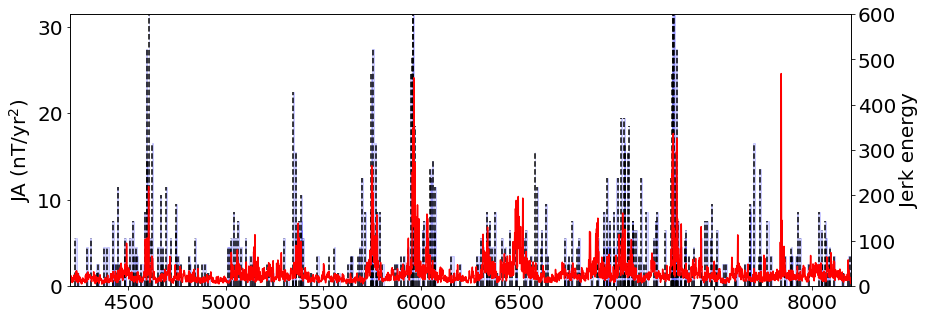

In [211]:
import matplotlib.colors as colors

TIMES_MIN, TIMES_MAX = window_start[0], window_end[window_index]

import matplotlib.colors as colors
fig, ax = plt.subplots( 1,1, figsize=(14,5))
axb = ax.twinx()
for i in run_components:
    if i == 0:
        data_timing, data_amplitude = jerk_data_stitch0[:,0], jerk_data_stitch0[:,1]
    elif i==1:
        data_timing, data_amplitude = jerk_data_stitch1[:,0], jerk_data_stitch1[:,1]
    else:
        data_timing, data_amplitude = jerk_data_stitch2[:,0], jerk_data_stitch2[:,1]
            

    number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
    number_amplitude_bins = 100
    time_range = [TIMES_MIN,TIMES_MAX]
    amplitude_range = [-50,50]
    jerks_info = find_jerks(data_timing, data_amplitude, number_time_bins, time_range, tau = 0.60)


    
    ymin = 0
    ymax = max(jerk[1] for jerk in jerks_info)
    ax.set_ylim([ymin,ymax])
    for jerk in jerks_info:
        ax.vlines(jerk[0], ymin, abs(jerk[1]), colors='k',linestyles='dashed')
        ax.fill_betweenx([ymin, abs(jerk[1])], jerk[2], jerk[3],alpha=0.15, color='blue')
    #plt.savefig('example2_posterior_with_jerks.pdf',bbox_inches='tight')

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
axb.plot(time_EJ, EJ ,'r')
axb.set_xlim(TIMES_MIN, TIMES_MAX )
axb.set_ylim(0,600)
#ax[3].set_title('Jerk energy')
axb.set_ylabel('Jerk energy',fontsize=20)
axb.tick_params(axis='both', which='major', labelsize=20)

ax.set_ylabel('JA (nT/yr$^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
axb.tick_params(axis='y', which='major', labelsize=20)

ax.set_xlim(TIMES_MIN, TIMES_MAX)
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)


In [229]:
time.shape

(50001,)

In [230]:
coeffs[time<=6000,:]

array([[ 6.36667203e+04, -3.65923563e+02, -2.20986012e+02, ...,
         6.68674362e-06,  2.45272393e-06,  1.20141812e-05],
       [ 6.36670314e+04, -3.66104985e+02, -2.18994449e+02, ...,
         6.72527099e-06,  2.34691048e-06,  1.19630179e-05],
       [ 6.36673371e+04, -3.66343151e+02, -2.17014460e+02, ...,
         6.76161751e-06,  2.23700381e-06,  1.19161758e-05],
       ...,
       [ 6.43043311e+04, -4.33079892e+02, -2.31463127e+03, ...,
         6.60882701e-06,  2.15083414e-05, -1.44241467e-05],
       [ 6.43097234e+04, -4.31107241e+02, -2.31369852e+03, ...,
         6.67306718e-06,  2.14558866e-05, -1.40889847e-05],
       [ 6.43152049e+04, -4.29095487e+02, -2.31278247e+03, ...,
         6.74207988e-06,  2.13963036e-05, -1.37357452e-05]])

In [231]:
Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs[time<=6000,:], radius, 30,30,nmax=13)
time_yearly = np.arange(int(time.min()), int(time.max())+1)



In [236]:
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), \
        np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )

In [235]:
time.shape

(9001,)